## Import

In [33]:
import os
pwd = os.path.abspath('.')
os.chdir(os.path.join(pwd, '../src/'))

In [34]:
from collections import Counter
import pandas as pd
import seaborn as sns
from core.environment import EnvironmentSettings
from string import Template
from core.column_definition import BaseColumns, CalculatedColumns

import datetime

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

#### Import Common Classes

In [36]:
from calculations.base import PriceCrossedAboveValueFlagWorker, PriceCrossedBelowValueFlagWorker

#### Helpers

In [37]:
def generate_signal_files(data, buy_flag_col_name, sell_flag_col_name, output_sub_folder):
  output_path = os.path.join('../output/trades/', output_sub_folder)
  if os.path.exists(output_path) == False:
    os.makedirs(output_path)

  for year in range(2016, 2024):
    print(f'Generating signal files for {year}')
    period_data = data[
      (data[CalculatedColumns.Year] == year) & \
      (data[CalculatedColumns.IsInDerivatives] == True)
    ]

    year_path = os.path.join(output_path, str(year))
    if os.path.exists(year_path) == False:
      os.makedirs(year_path)
    buy_signals = period_data[period_data[buy_flag_col_name] == True]
    sell_signals = period_data[period_data[sell_flag_col_name] == True]
    
    buy_signals.to_csv(os.path.join(year_path, 'buy_signal_symbols.csv'))
    sell_signals.to_csv(os.path.join(year_path, 'sell_signal_symbols.csv'))

In [38]:
def get_fwd_looking_price_cols(data: pd.DataFrame):
  return [x for x in data.columns if 'HighestPercFallInNext' in x], \
    [x for x in data.columns if 'HighestPercRiseInNext' in x]

In [39]:
def get_col_for_name(df: pd.DataFrame, name: str):
  return [col for col in df.columns if name in col] 

In [40]:
def get_n_days_wise_data(data: pd.DataFrame, groupby_col: str = None):
  fwd_looking_price_fall_cols, fwd_looking_price_rise_cols = get_fwd_looking_price_cols(data)

  results = None
  if groupby_col is None:
    results = data[fwd_looking_price_rise_cols + fwd_looking_price_fall_cols].median()
  else:
    results = data.groupby(CalculatedColumns.Year)[fwd_looking_price_rise_cols + fwd_looking_price_fall_cols].median()
  
  n_days = [x.replace('HighestPercFallIn', '') for x in fwd_looking_price_fall_cols]
  col_types = ['HighestPercFall', 'HighestPercRise']
  data = pd.DataFrame()
  for col_type in col_types:
    if groupby_col is None:
      row = {}
      for n_day in n_days:
        row[n_day] = results[col_type + 'In' + n_day]
      data = pd.concat([data, pd.DataFrame(row, index=[col_type])])
    else:
      row = {}
      for idx in results.index:
        row[groupby_col] = idx
        for n_day in n_days:
          row[n_day] = results.loc[idx][col_type + 'In' + n_day]
        data = pd.concat([data, pd.DataFrame(row, index=[col_type])])
  if groupby_col is None:
    return data
  else:
    return data.sort_values(groupby_col)

In [41]:
def get_signal_results(data: pd.DataFrame, signal_col: str, groupby_col: str = CalculatedColumns.Year):
  signal_data = data[(data[signal_col] == True)
    &
    (data[CalculatedColumns.IsInDerivatives] == True)
  ]
  signal_results = get_n_days_wise_data(signal_data, groupby_col)
  return signal_results

def get_buy_sell_signal_results(data: pd.DataFrame, buy_signal_col: str, sell_signal_col: str, 
    groupby_col: str = CalculatedColumns.Year):
  
  buy_signal_results = None
  sell_signal_results = None

  if buy_signal_col is not None:
    buy_signal_results = get_signal_results(data, buy_signal_col, groupby_col)
    print('Buy Singal Results')
    display(buy_signal_results)
  
  if sell_signal_col is not None:
    print('Sell Singal Results')
    sell_signal_results = get_signal_results(data, sell_signal_col, groupby_col)
    display(sell_signal_results)

  return buy_signal_results, sell_signal_results

In [42]:
def get_price_change_correlation_to_signal(data: pd.DataFrame, price_change_flag: str, signal_col_str: str):
  result = []
  flag_cols = [x for x in data.columns if signal_col_str in x]
  for col in flag_cols:
    corr_result = data[
      (data[CalculatedColumns.IsInDerivatives] == True) 
    ][[col, price_change_flag]].corr()
    value = corr_result[corr_result.columns[1]].values[0]
    display(corr_result)
    result.append([col, price_change_flag, value])

  result_df = pd.DataFrame(result, columns=['Flag', 'Fall', 'Corr Value'])
  result_df.iloc[result_df['Corr Value'].abs().argsort()].reset_index(drop=True)

#### Process Data

In [43]:
from datareader.data_reader import BhavCopyReader
reader = BhavCopyReader()

from datareader.data_reader import MultiDatesDataReader, DateRangeDataReader, NseDerivatiesOldReader

multidates_reader = MultiDatesDataReader(reader)
daterange_reader = DateRangeDataReader(reader)

from core.core import MarketDaysHelper, TypeHelper

In [44]:
yest = datetime.date.today() + datetime.timedelta(days=-1)

In [45]:
from dataprocess.data_processor import HistoricalDataProcessor, MultiDataCalculationPipelines, CalculationPipelineBuilder, HistoricalDataProcessOptions
from calculations.equity import IsInDerivativesFlagCalculationWorker
from calculations.base import DatePartsCalculationWorker, StochRsiCalculationWorker, VwapCalculationWorker, StdDevCalculationWorker
options = HistoricalDataProcessOptions()
options.include_monthly_data = False
options.include_annual_data = False
histDataProcessor = HistoricalDataProcessor(options)

In [46]:
year_start = datetime.date(2016, 1, 1)
to_date = yest
result = histDataProcessor.process(reader, {'from_date': year_start, 'to_date': to_date})

Started to read data
get_data took 8 seconds
get_manual_data took 0 seconds
Started basic calculation
add_basic_calc took 1 seconds
process took 8 seconds


In [47]:
pipelines = MultiDataCalculationPipelines()
pipelines.set_item('date_parts', CalculationPipelineBuilder.create_pipeline_for_worker(DatePartsCalculationWorker()))
pipelines.set_item('derivatives_flag', CalculationPipelineBuilder.create_pipeline_for_worker(IsInDerivativesFlagCalculationWorker()))
pipelines.set_item('sma', CalculationPipelineBuilder.create_sma_calculation_pipeline())
pipelines.set_item('vwap', CalculationPipelineBuilder.create_pipeline_for_workers([VwapCalculationWorker(14), PriceCrossedAboveValueFlagWorker(CalculatedColumns.Vwap)]))
pipelines.set_item('bb', CalculationPipelineBuilder.create_bb_calculation_pipeline())
pipelines.set_item('rsi', CalculationPipelineBuilder.create_rsi_calculation_pipeline(crossing_above_flag_value = 75, crossing_below_flag_value = 30))
pipelines.set_item('stoch_rsi', CalculationPipelineBuilder.create_stoch_rsi_calculation_pipeline())
pipelines.set_item('foward_looking_fall', CalculationPipelineBuilder.create_forward_looking_price_fall_pipeline(range(1, 11)))
pipelines.set_item('foward_looking_rise', CalculationPipelineBuilder.create_forward_looking_price_rise_pipeline(range(1, 11)))
histDataProcessor.set_calculation_pipelines(pipelines)

In [48]:
histDataProcessor.run_calculation_pipelines()

DatePartsCalculationWorker took 1 seconds
IsInDerivativesFlagCalculationWorker took 0 seconds
SMACalculationWorker took 1 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
SMACalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
SMACalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
VwapCalculationWorker took 1 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
StdDevCalculationWorker took 1 seconds
StdDevCalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
StdDevCalculationWorker took 0 seconds
PriceCrossedBelowValueFlagWorker took 0 seconds
PriceCrossedAboveValueFlagWorker took 0 seconds
RsiCalculationWorker took 8 seconds
ValueCrossedAboveFlagWorker took 1 seconds
ValueCrossedBelowFlagWorker took 1 se

In [49]:
daily_data = result.get_daily_data()

#### Setup Common Variables

In [50]:
fwd_looking_price_fall_cols, fwd_looking_price_rise_cols = get_fwd_looking_price_cols(daily_data)

In [51]:
base_disp_cols = TypeHelper.get_class_static_values(BaseColumns)

## Analysis

#### RSI

In [55]:
buy_signal_result, sell_signal_result = get_buy_sell_signal_results(daily_data, CalculatedColumns.RsiCrossedBelow, CalculatedColumns.RsiCrossedAbove, CalculatedColumns.Year)

Buy Singal Results


,Year,Next1Days,Next2Days,Next3Days,Next4Days,Next5Days,Next6Days,Next7Days,Next8Days,Next9Days,Next10Days
HighestPercFall,2023,-0.039952,0.080743,0.202632,0.205506,0.407725,0.375987,0.401084,0.594573,0.745758,1.269514
HighestPercRise,2023,1.897832,2.322756,2.485920,2.744818,2.978575,3.739161,3.973023,4.161850,4.296592,4.415323


Sell Singal Results


,Year,Next1Days,Next2Days,Next3Days,Next4Days,Next5Days,Next6Days,Next7Days,Next8Days,Next9Days,Next10Days
HighestPercFall,2023,1.716977,2.389573,3.017137,3.510236,3.397493,3.423158,4.065072,3.899713,3.670145,3.636361
HighestPercRise,2023,0.627565,0.659184,0.687593,0.786925,0.766715,0.723054,0.662637,0.662637,1.133297,1.324548


#### SMA

In [56]:
buy_signal_result, sell_signal_result = get_buy_sell_signal_results(
  daily_data, 
  'PriceCrossedBelowSma200', 
  'PriceCrossedAboveSma200', 
  CalculatedColumns.Year
)

KeyError: 'Year'

#### Stochastic RSI 

In [57]:
get_buy_sell_signal_results(daily_data, 
  CalculatedColumns.StochRsi_KCrossedBelow, CalculatedColumns.StochRsi_KCrossedAbove,
  CalculatedColumns.Year
)

Buy Singal Results


,Year,Next1Days,Next2Days,Next3Days,Next4Days,Next5Days,Next6Days,Next7Days,Next8Days,Next9Days,Next10Days
HighestPercFall,2023,-0.239542,1.642174,1.711122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HighestPercRise,2023,3.007575,2.037645,1.948379,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Sell Singal Results


,Year,Next1Days,Next2Days,Next3Days,Next4Days,Next5Days,Next6Days,Next7Days,Next8Days,Next9Days,Next10Days
HighestPercFall,2023,1.957151,2.866034,3.271155,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HighestPercRise,2023,0.469838,0.727584,1.337823,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(                 Year  Next1Days  Next2Days  Next3Days  Next4Days  Next5Days  \
 HighestPercFall  2023  -0.239542   1.642174   1.711122        NaN        NaN   
 HighestPercRise  2023   3.007575   2.037645   1.948379        NaN        NaN   
 
                  Next6Days  Next7Days  Next8Days  Next9Days  Next10Days  
 HighestPercFall        NaN        NaN        NaN        NaN         NaN  
 HighestPercRise        NaN        NaN        NaN        NaN         NaN  ,
                  Year  Next1Days  Next2Days  Next3Days  Next4Days  Next5Days  \
 HighestPercFall  2023   1.957151   2.866034   3.271155        NaN        NaN   
 HighestPercRise  2023   0.469838   0.727584   1.337823        NaN        NaN   
 
                  Next6Days  Next7Days  Next8Days  Next9Days  Next10Days  
 HighestPercFall        NaN        NaN        NaN        NaN         NaN  
 HighestPercRise        NaN        NaN        NaN        NaN         NaN  )

#### VWAP

In [58]:
buy_signal_results, sell_signal_results = get_buy_sell_signal_results(daily_data, 
  None, CalculatedColumns.PriceCrossedAboveVwap,
  CalculatedColumns.Year
)

Sell Singal Results


,Year,Next1Days,Next2Days,Next3Days,Next4Days,Next5Days,Next6Days,Next7Days,Next8Days,Next9Days,Next10Days
HighestPercFall,2023,1.062867,1.436602,1.769970,1.967932,2.137148,2.344614,2.639041,2.846505,3.020398,3.268372
HighestPercRise,2023,0.789810,1.255407,1.590051,1.913440,2.220717,2.339601,2.601888,2.692834,2.993186,3.024194


#### BB

In [59]:
buy_signal_results, sell_signal_results = get_buy_sell_signal_results(daily_data, 
  'PriceCrossedBelowBb200Dev3Lower', 'PriceCrossedAboveBb200Dev3Upper',
  CalculatedColumns.Year
)

KeyError: 'Year'

#### Price change correlation

In [60]:
get_fwd_looking_price_fall_cols, get_fwd_looking_price_rise_cols = get_fwd_looking_price_cols(daily_data)

In [61]:
price_fall_flag_col = 'PriceFellMoreThanThresholdPerc'
daily_data[price_fall_flag_col] = daily_data['HighestPercFallInNext10Days'] >= 5

get_price_change_correlation_to_signal(daily_data, price_fall_flag_col, 'Above')

,PriceCrossedAboveSma50,PriceFellMoreThanThresholdPerc
PriceCrossedAboveSma50,NaN,NaN
PriceFellMoreThanThresholdPerc,NaN,1.0


,PriceCrossedAboveSma100,PriceFellMoreThanThresholdPerc
PriceCrossedAboveSma100,NaN,NaN
PriceFellMoreThanThresholdPerc,NaN,1.0


,PriceCrossedAboveSma200,PriceFellMoreThanThresholdPerc
PriceCrossedAboveSma200,NaN,NaN
PriceFellMoreThanThresholdPerc,NaN,1.0


,PriceCrossedAboveVwap,PriceFellMoreThanThresholdPerc
PriceCrossedAboveVwap,1.000000,0.060375
PriceFellMoreThanThresholdPerc,0.060375,1.000000


,PriceCrossedAboveBb200Dev2Upper,PriceFellMoreThanThresholdPerc
PriceCrossedAboveBb200Dev2Upper,NaN,NaN
PriceFellMoreThanThresholdPerc,NaN,1.0


,PriceCrossedAboveBb200Dev3Upper,PriceFellMoreThanThresholdPerc
PriceCrossedAboveBb200Dev3Upper,NaN,NaN
PriceFellMoreThanThresholdPerc,NaN,1.0


,RsiCrossedAbove,PriceFellMoreThanThresholdPerc
RsiCrossedAbove,1.000000,-0.010682
PriceFellMoreThanThresholdPerc,-0.010682,1.000000


,StochRsi_KCrossedAbove,PriceFellMoreThanThresholdPerc
StochRsi_KCrossedAbove,1.000000,-0.019569
PriceFellMoreThanThresholdPerc,-0.019569,1.000000


,StochRsi_DCrossedAbove,PriceFellMoreThanThresholdPerc
StochRsi_DCrossedAbove,1.000000,-0.007983
PriceFellMoreThanThresholdPerc,-0.007983,1.000000


In [62]:
price_rise_flag_col = 'PriceRiseMoreThanThresholdPerc'
daily_data[price_rise_flag_col] = daily_data['HighestPercRiseInNext10Days'] >= 5

get_price_change_correlation_to_signal(daily_data, price_rise_flag_col, 'Below')

,PriceCrossedBelowSma50,PriceRiseMoreThanThresholdPerc
PriceCrossedBelowSma50,NaN,NaN
PriceRiseMoreThanThresholdPerc,NaN,1.0


,PriceCrossedBelowSma100,PriceRiseMoreThanThresholdPerc
PriceCrossedBelowSma100,NaN,NaN
PriceRiseMoreThanThresholdPerc,NaN,1.0


,PriceCrossedBelowSma200,PriceRiseMoreThanThresholdPerc
PriceCrossedBelowSma200,NaN,NaN
PriceRiseMoreThanThresholdPerc,NaN,1.0


,PriceCrossedBelowBb200Dev2Lower,PriceRiseMoreThanThresholdPerc
PriceCrossedBelowBb200Dev2Lower,NaN,NaN
PriceRiseMoreThanThresholdPerc,NaN,1.0


,PriceCrossedBelowBb200Dev3Lower,PriceRiseMoreThanThresholdPerc
PriceCrossedBelowBb200Dev3Lower,NaN,NaN
PriceRiseMoreThanThresholdPerc,NaN,1.0


,RsiCrossedBelow,PriceRiseMoreThanThresholdPerc
RsiCrossedBelow,1.000000,0.030483
PriceRiseMoreThanThresholdPerc,0.030483,1.000000


,StochRsi_KCrossedBelow,PriceRiseMoreThanThresholdPerc
StochRsi_KCrossedBelow,1.000000,-0.023304
PriceRiseMoreThanThresholdPerc,-0.023304,1.000000


,StochRsi_DCrossedBelow,PriceRiseMoreThanThresholdPerc
StochRsi_DCrossedBelow,1.000000,-0.011638
PriceRiseMoreThanThresholdPerc,-0.011638,1.000000


<AxesSubplot:>

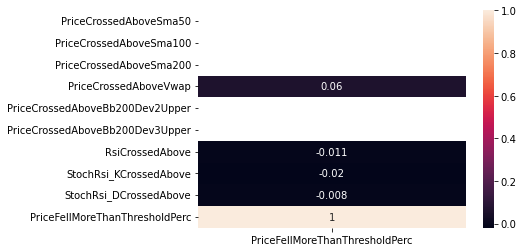

In [63]:
flag_cols = [x for x in daily_data.columns if 'Above' in x]
sns.heatmap(
  daily_data[ \
    (daily_data[CalculatedColumns.IsInDerivatives] == True) \
  ][flag_cols + [price_fall_flag_col]].corr()[[price_fall_flag_col]]
, annot=True)

<AxesSubplot:>

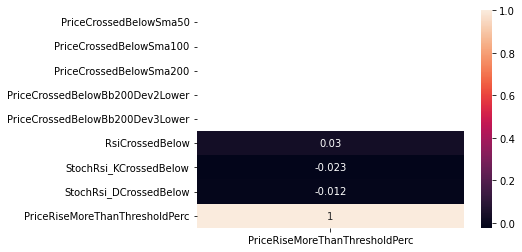

In [64]:
flag_cols = [x for x in daily_data.columns if 'Below' in x]
sns.heatmap(
  daily_data[ \
    (daily_data[CalculatedColumns.IsInDerivatives] == True) \
  ][flag_cols + [price_rise_flag_col]].corr()[[price_rise_flag_col]]
, annot=True)

In [ ]:
daily_data[
    (daily_data[CalculatedColumns.IsInDerivatives] == True)  \
  ][['RsiCrossedAndPriceAboveVwap', price_fall_flag_col]].corr()

,RsiCrossedAndPriceAboveVwap,PriceFellMoreThanThresholdPercInNext5Days
RsiCrossedAndPriceAboveVwap,1.000000,0.045099
PriceFellMoreThanThresholdPercInNext5Days,0.045099,1.000000


In [ ]:
print(daily_data[
    (daily_data[CalculatedColumns.IsInDerivatives] == True) & \
    (daily_data[price_fall_flag_col] == True)
  ][BaseColumns.Identifier].count())

print(daily_data[
    (daily_data[CalculatedColumns.IsInDerivatives] == True) & \
    (daily_data[price_fall_flag_col] == False) & \
    (daily_data[CalculatedColumns.RsiCrossedAbove] == False)
  ][BaseColumns.Identifier].count())

84438
249494


#### Expiry Analysis

In [ ]:
from datareader.data_reader import NseDerivatiesOldReader

In [ ]:
data = multidates_reader.read(MarketDaysHelper.get_monthly_expiry_dates(6))
data['Date'].unique()

array(['2023-09-28T00:00:00.000000000', '2023-08-31T00:00:00.000000000',
       '2023-07-27T00:00:00.000000000', '2023-06-28T00:00:00.000000000',
       '2023-05-25T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
data['CloseToPrevCloseChangePerc'] = (data['Close'] / data['PreviousClose'] - 1) * 100
data['OpenToPrevCloseChangePerc'] = (data['Open'] / data['PreviousClose'] - 1) * 100

display_columns = ['Identifier', 'PreviousClose', 'Open', 'High', 'Low', 'Close', 'Date', 
                    'CloseToPrevCloseChangePerc', 'OpenToPrevCloseChangePerc'
                    ]

In [ ]:
data.reindex(data['CloseToPrevCloseChangePerc'].abs().sort_values(ascending=False).index)[data['Identifier'].isin(derivative_instruments)][display_columns].head(20)
#data['Date'].dt.strftime('%d-%b-%Y').str.upper()

In [ ]:
quantile = data.sort_values(by='OpenToPrevCloseChangePerc', ascending=True)['OpenToPrevCloseChangePerc'].quantile(q=0.99)
data[data['OpenToPrevCloseChangePerc'] >= quantile][display_columns]

### Debug

In [ ]:
def format_datetime(dt_series, format):
    def get_split_date(strdt):
        split_date = strdt.split()
        str_date = split_date[1] + ' ' + split_date[2] + ' ' + split_date[5] + ' ' + split_date[3]
        return str_date

    dt_series = pd.to_datetime(dt_series.apply(lambda x: get_split_date(x)), format = format)

    return dt_series

In [ ]:
result = histDataProcessor.process(reader, {'from_date': datetime.date(2023, 7, 1), 'to_date': datetime.date.today()})
#identifier_grouped_data = result.get_identifier_grouped()
data = result.get_daily_data()

Started to read data
Reading data from 2023-08-09 to 2023-08-10
https://archives.nseindia.com/content/historical/EQUITIES/2023/AUG/cm10AUG2023bhav.csv.zip
The read operation timed out date(2023, 08, 10),
Saving data to file: ../../_data/processed/historical/Equities.csv
get_data took 46 seconds
get_manual_data took 0 seconds
Started basic calculation
add_basic_calc took 1 seconds
Started periodic calculation for Month
add_monthly_growth_calc took 3 seconds
Started periodic calculation for Year
add_yearly_growth_calc took 1 seconds
process took 51 seconds


In [ ]:
_time_window = 14

def calculate_wsm_average(raw_data, data, avg_col_name, abs_col_name):
  step = 1
  for i, row in enumerate(data[avg_col_name].iloc[_time_window + step:]):
    raw_data.at[data.index[i + _time_window + step], avg_col_name] =\
      (data[avg_col_name].iloc[i + _time_window] *
      (_time_window - step) +
      data[abs_col_name].iloc[i + _time_window + step])\
      / _time_window

In [ ]:
identifier_grouped_data = data.groupby(BaseColumns.Identifier)
data[CalculatedColumns.ClosePriceDiff] = identifier_grouped_data[BaseColumns.Close].transform(lambda x: x.diff(1))
data[CalculatedColumns.Gain] = identifier_grouped_data[CalculatedColumns.ClosePriceDiff].transform(lambda x: x.clip(lower=0).round(2))
data[CalculatedColumns.Loss] = identifier_grouped_data[CalculatedColumns.ClosePriceDiff].transform(lambda x: x.clip(upper=0).abs().round(2))

data[CalculatedColumns.ClosePriceDiff].fillna(0)
data[CalculatedColumns.Gain].fillna(0)
data[CalculatedColumns.Loss].fillna(0)

# Get initial Averages
data[CalculatedColumns.AvgGain] = identifier_grouped_data[CalculatedColumns.Gain].transform(lambda x: 
                                    x.rolling(window=_time_window, min_periods=_time_window).mean())
data[CalculatedColumns.AvgLoss] = identifier_grouped_data[CalculatedColumns.Loss].transform(lambda x: 
                                    x.rolling(window=_time_window, min_periods=_time_window).mean())

for identifier in data['Identifier'].unique():
  calculate_wsm_average(data, identifier_grouped_data.get_group(identifier), CalculatedColumns.AvgGain, CalculatedColumns.Gain) 
  calculate_wsm_average(data, identifier_grouped_data.get_group(identifier), CalculatedColumns.AvgLoss, CalculatedColumns.Loss)

data[CalculatedColumns.RelativeStrength] = data[CalculatedColumns.AvgGain] / data[CalculatedColumns.AvgLoss]
data[CalculatedColumns.RelativeStrengthIndex] = 100 - (100 / (1.0 + data[CalculatedColumns.RelativeStrength]))

In [ ]:
data[data[BaseColumns.Identifier] == 'TVSMOTOR'].tail(5)[[BaseColumns.Date, CalculatedColumns.RelativeStrengthIndex]]

,Date,Rsi
42317,2023-08-03,56.345408
44033,2023-08-04,51.629586
45742,2023-08-07,49.179718
50319,2023-08-08,46.982477
51286,2023-08-09,51.312888
